In [1]:
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from collections import Counter

In [4]:
truth = pd.read_csv("data/allele.deltas.txt", sep='\t')
props = {"HG00438": 0.5 / 100,
         "HG002":   2 / 100,
         "HG02257": 2 / 100,
         "HG02486": 2 / 100,
         "HG02622": 10 / 100,
         "HG005":   83.5 / 100}
percents = []
names = []
for i in truth.columns[3:]:
    percents.append(props[i.split('.')[0]] / 2)
    names.append(i)
percents = pd.Series(percents, index=names)    

truth.set_index(['chrom', 'start', 'end'], inplace=True)
samples = list(truth.columns)

In [30]:
fn = "data/chr1.bcm.test.qdpi.tsv.gz"
data = pd.read_csv(fn, sep='\t', names=["chrom", "start", "end", "data"])

data['data'] = data['data'].apply(lambda x: json.loads(x))

data.set_index(['chrom', 'start', 'end'], inplace=True)
full_data = truth.join(data, how='left').dropna()

full_data['coverage'] = full_data['data'].apply(lambda x: x[0])
full_data['alt_read_coverage'] = full_data['data'].apply(lambda x: len(x[2]))
full_data['ref_read_coverage'] = full_data['coverage'] - full_data['alt_read_coverage']
                                                         

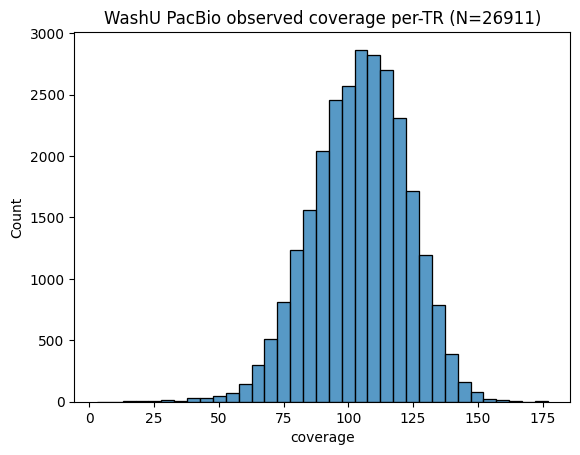

In [28]:
p =  sb.histplot(data=full_data, x='coverage', binwidth=5)
_ = p.set(title=f"WashU PacBio observed coverage per-TR (N={len(full_data)})")

In [38]:
def combine_and_average(numbers, delta=5):
    """
    Numbers that are within delta are combined and averaged
    returns a dictionary of original value mapped to its new average bin
    """
    combined = {}
    current_group = [numbers[0]]

    for num in numbers[1:]:
        if abs(num - current_group[-1]) <= delta:
            current_group.append(num)
        else:
            avg = sum(current_group) / len(current_group)
            for n in current_group:
                combined[n] = avg
            current_group = [num]

    avg = sum(current_group) / len(current_group)
    for n in current_group:
        combined[n] = avg
    
    return combined


In [44]:
rows = []
for _, row in full_data.iterrows():
    observed = Counter(row['data'][2])

    expected_unaltered = Counter()
    for size, percent in zip(row[samples].values, percents[samples]):
        expected_unaltered[size] += percent
    
    expected = Counter()
    expected_cnt = Counter()
    vals = sorted(list(expected_unaltered.keys()))
    dedup = combine_and_average(vals, delta=2)
    for k, v in dedup.items():
        expected[v] += expected_unaltered[k]
        expected_cnt[v] += 1
        
    # Dedup the expected -- If they're within 5bp, combine them.
    closest_numbers = dict([(num, min(expected.keys(), key=lambda x: abs(x - num))) for num in observed])

    # Observed mapto Expected
    summed_observed = Counter()
    for o, e in closest_numbers.items():
        summed_observed[e] += observed[o]
    summed_observed

    chrom, start, end = row.name
    tot_cov = row['coverage']
    if tot_cov == 0:
        continue
    for k in expected.keys():
        obs = summed_observed[k]
        rows.append((chrom, start, end, k, 
                     expected_cnt[k], obs, round(obs / tot_cov, 4), 
                     expected[k], row['coverage']))
        
measure = pd.DataFrame(rows, 
                       columns=["chrom", "start", "end", 
                                "expected_len",
                                "num_collapsed",
                                "read_count", 
                                "observed_vaf", 
                                "expected_vaf", 
                                'coverage'])

measure['vaf_bin'] = pd.cut(measure['expected_vaf'], bins=[0, 0.05, 0.3, 0.7, 1], labels=["Ultra-Low", "Low", "Medium", "High"])
measure['VAF delta'] = measure["observed_vaf"] - measure["expected_vaf"]

PearsonRResult(statistic=0.9594680488930863, pvalue=0.0)
0.007576570622332692


count    21323.000000
mean         0.002763
std          0.087002
min         -0.863100
25%         -0.012600
50%          0.007500
75%          0.029800
max          0.900000
Name: VAF delta, dtype: float64

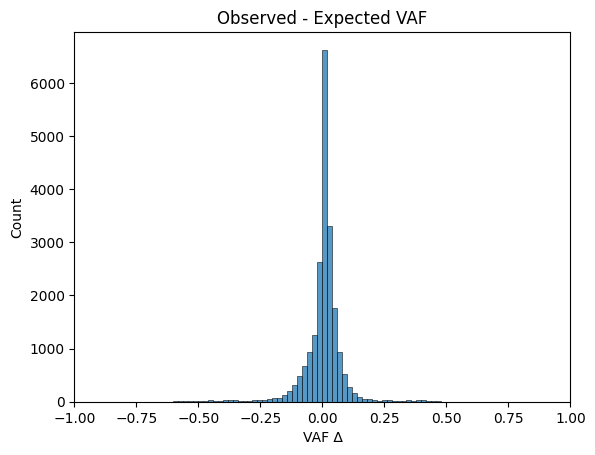

In [62]:
view = measure[(measure['read_count'] != 0) 
              & (measure['expected_len'].abs() >= 5)]
p = sb.histplot(data=view, x="VAF delta", binwidth=0.02)
p.set(title="Observed - Expected VAF", xlabel="VAF ∆", xlim=(-1,1))

print(pearsonr(view['observed_vaf'], view['expected_vaf']))
MSE = ((view['expected_vaf'] - view['observed_vaf']) ** 2).sum()  / len(view)
print(MSE)
view['VAF delta'].describe()

<Axes: xlabel='VAF delta', ylabel='coverage'>

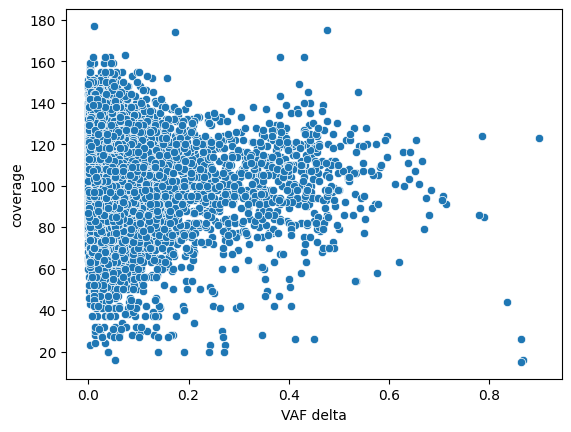

In [63]:
sb.scatterplot(data=view, x=view['VAF delta'].abs(), y='coverage')

In [59]:
pearsonr(view['VAF delta'].abs(), view['coverage'])

PearsonRResult(statistic=-0.018398016587624744, pvalue=0.038401351659267925)

In [50]:
parts = []
mask = (view['expected_vaf'] < 0.30)
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['expected_vaf'].between(0.30, 0.70)
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['expected_vaf'] > 0.70
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

vaf_report = pd.concat(parts, axis=1)
vaf_report.columns = ["Low VAF", "Medium VAF", "High VAF"]

vaf_report.loc[['count', 'mean', '50%', 'std', 'PearsonR', 'MSE']]

,Low VAF,Medium VAF,High VAF
count,8131.000000,2994.000000,1541.000000
mean,0.029866,-0.028806,-0.081944
50%,0.015000,-0.023250,-0.039200
std,0.058225,0.073174,0.127803
PearsonR,0.534601,0.632575,0.635039
MSE,0.004282,0.006182,0.023038


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


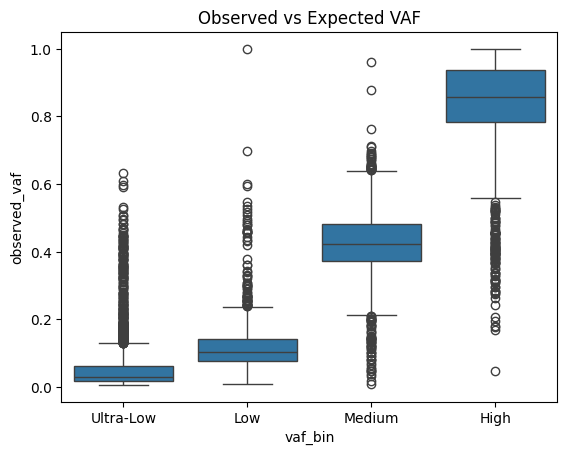

In [ ]:
p = sb.boxplot(data=view, x='vaf_bin', y='observed_vaf')
#sb.kdeplot(data=comp_vars, x="predicted_vaf", y="expected_vaf", hue="vaf_bin")
p.set(title="Observed vs Expected VAF")
plt.legend().remove()

# Max Recall Estimate

In [ ]:
x = measure[(measure['read_count'] == 0) & (measure['expected_len'].abs() >= 50)]
len(x)

327

In [ ]:
len(measure[(measure['expected_len'].abs() >= 50)])

2390

In [ ]:
1 - (len(x) / len(measure[(measure['expected_len'].abs() >= 50)]))

0.8631799163179916

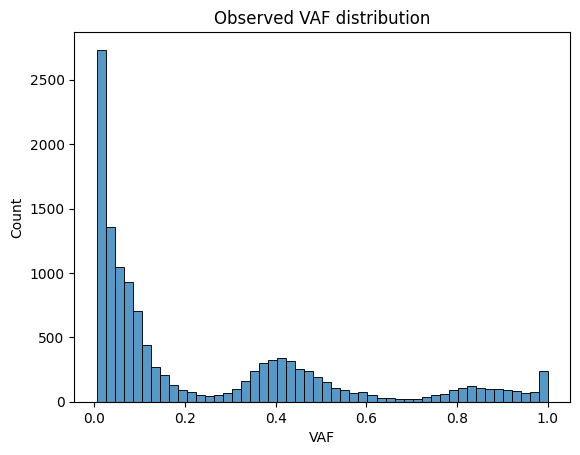

In [57]:
p = sb.histplot(data=view, x="observed_vaf", binwidth=0.02)
_ = p.set(title="Observed VAF distribution", xlabel="VAF")

In [20]:
subset = measure[(measure['expected_len'].abs() >= 50)]
low = (subset['expected_vaf'] < 0.30)
medium = subset['expected_vaf'].between(0.30, 0.70)
high = subset['expected_vaf'] > 0.70

def foo(x):
    missing = (x['read_count'] == 0).sum()
    total = len(x)
    tp = total - missing
    return [tp, missing, total, tp/total]

r = pd.DataFrame([foo(subset[x]) for x in [low, medium, high]], columns=['TP', 'FN', 'total', 'recall'])
r['VAF Bin'] = ['Low', 'Medium', 'High']
r

,TP,FN,total,recall,VAF Bin
0,27611,8609,36220,0.762314,Low
1,10733,37,10770,0.996565,Medium
2,3682,6,3688,0.998373,High


In [16]:
measure

,chrom,start,end,expected_len,read_count,observed_vaf,expected_vaf,vaf_bin,VAF delta
0,chr1,840404,840466,0.00,90,0.9184,0.9900,High,-0.0716
1,chr1,839177,839680,-42.00,95,0.9794,0.9275,High,0.0519
2,chr1,839177,839680,0.00,2,0.0206,0.0625,Low,-0.0419
3,chr1,850622,850687,0.00,19,0.1696,0.9900,High,-0.8204
4,chr1,853415,853930,-49.00,98,0.9703,0.9275,High,0.0428
...,...,...,...,...,...,...,...,...,...
465255,chr9,138107101,138107291,1.75,91,1.0000,0.9800,High,0.0200
465256,chr9,138107726,138108356,-6.50,71,0.8353,0.8575,High,-0.0222
465257,chr9,138107726,138108356,1.00,12,0.1412,0.1325,Low,0.0087
465258,chr9,138099084,138099847,-32.00,1,0.0093,0.0100,Low,-0.0007


In [41]:
washu_pacbio = measure.copy()

In [46]:
bcm_ont = measure.copy()

In [53]:
bcm_pacbio = measure.copy()

In [60]:
bo = bcm_ont[(bcm_ont['expected_len'].abs() >= 50) & (bcm_ont['read_count'] >= 1)].set_index(['chrom', 'start', 'end', 'expected_len'])
bp = bcm_pacbio[(bcm_pacbio['expected_len'].abs() >= 50) & (bcm_pacbio['read_count'] >= 1)].set_index(['chrom', 'start', 'end', 'expected_len'])
wp = washu_pacbio[(washu_pacbio['expected_len'].abs() >= 50) & (washu_pacbio['read_count'] >= 1)].set_index(['chrom', 'start', 'end', 'expected_len'])

In [61]:
bo.head()

read_count  observed_vaf  expected_vaf  \
chrom start  end    expected_len                                           
chr1  872478 873203 -210.0                41        0.4940        0.4175   
      904387 904830 -98.0                 32        0.3368        0.4200   
                     79.0                  9        0.0947        0.0500   
                     354.0                 7        0.0737        0.0500   
      866379 867217  147.0                92        0.9787        0.9650   

                                 vaf_bin  VAF delta  
chrom start  end    expected_len                     
chr1  872478 873203 -210.0        Medium     0.0765  
      904387 904830 -98.0         Medium    -0.0832  
                     79.0            Low     0.0447  
                     354.0           Low     0.0237  
      866379 867217  147.0          High     0.0137

In [86]:
x = bo.join(bp, lsuffix='_bont', rsuffix='_bpac', how='outer')

In [87]:
x[['read_count_bont', 'read_count_bpac']].isna().value_counts().unstack()

read_count_bpac,False,True
read_count_bont,,
False,38087.0,5243.0
True,3939.0,NaN


In [80]:
x = bp.join(wp, lsuffix='_bpac', rsuffix='_wpac', how='outer')

In [83]:
x[['read_count_wpac', 'read_count_bpac']].isna().value_counts().unstack()

read_count_bpac,False,True
read_count_wpac,,
False,37340.0,4396.0
True,4686.0,NaN


In [93]:
x = bo.join(wp, lsuffix='_bont', rsuffix='_wpac', how='outer')
x[['read_count_bont', 'read_count_wpac']].isna().value_counts().unstack()

read_count_wpac,False,True
read_count_bont,,
False,37941.0,5389.0
True,3795.0,NaN


In [89]:
y = x.join(wp, how='outer')

In [90]:
both_b = y[(~y['read_count_bont'].isna() == ~y['read_count_bpac'].isna())]

In [91]:
both_b[['read_count', 'read_count_bpac']].isna().value_counts().unstack()

read_count_bpac,False,True
read_count,,
False,35017.0,1472.0
True,3070.0,NaN


In [75]:
both_b['read_count_bpac'].isna().value_counts()

read_count_bpac
False    38087
True      1472
Name: count, dtype: int64

In [77]:
both_b['read_count'].isna().value_counts()

read_count
False    36489
True      3070
Name: count, dtype: int64

# Obs - Exp VAF by Coverage

In [25]:
measure

,chrom,start,end,expected_len,read_count,observed_vaf,expected_vaf,vaf_bin,VAF delta,orig_coverage
0,chr1,840404,840466,0.00,90,0.9184,0.9900,High,-0.0716,97.996516
1,chr1,839177,839680,-42.00,95,0.9794,0.9275,High,0.0519,96.998162
2,chr1,839177,839680,0.00,2,0.0206,0.0625,Low,-0.0419,97.087379
3,chr1,850622,850687,0.00,19,0.1696,0.9900,High,-0.8204,112.028302
4,chr1,853415,853930,-49.00,98,0.9703,0.9275,High,0.0428,100.999691
...,...,...,...,...,...,...,...,...,...,...
465255,chr9,138107101,138107291,1.75,91,1.0000,0.9800,High,0.0200,91.000000
465256,chr9,138107726,138108356,-6.50,71,0.8353,0.8575,High,-0.0222,84.999401
465257,chr9,138107726,138108356,1.00,12,0.1412,0.1325,Low,0.0087,84.985836
465258,chr9,138099084,138099847,-32.00,1,0.0093,0.0100,Low,-0.0007,107.526882


In [83]:
import sys
measure['coverage_bin'] = pd.cut(measure['orig_coverage'], bins=[0, 72, 104, sys.maxsize], labels=["<72", "[72,104)", "≥104"])

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

[Text(0.5, 1.0, 'Observed - Expected VAF'), Text(0.5, 0, 'VAF ∆'), (-1.0, 1.0)]

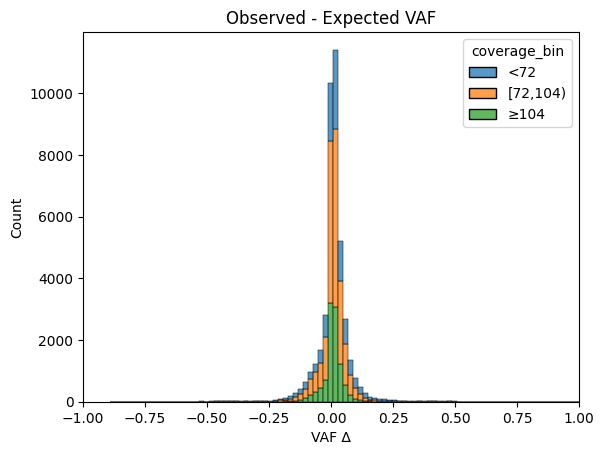

In [84]:
view = measure[(measure['read_count'] != 0) 
              & (measure['expected_len'].abs() >= 50)]
p = sb.histplot(data=view, x="VAF delta", binwidth=0.02, hue='coverage_bin', multiple='stack')
p.set(title="Observed - Expected VAF", xlabel="VAF ∆", xlim=(-1,1))

In [85]:
parts = []
mask = (view['coverage_bin'] == "<72")
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['coverage_bin'] == "[72,104)"
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['coverage_bin'] == "≥104"
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

cov_report = pd.concat(parts, axis=1)
cov_report.columns = ["Low Cov", "Medium Cov", "High Cov"]

cov_report.loc[['count', 'mean', '50%', 'std', 'PearsonR', 'MSE']]

,Low Cov,Medium Cov,High Cov
count,10691.000000,20932.000000,10403.000000
mean,0.011488,0.007111,0.004010
50%,0.012200,0.009500,0.006700
std,0.098688,0.061077,0.055039
PearsonR,0.932930,0.976196,0.981030
MSE,0.009870,0.003781,0.003045


In [86]:
measure[(measure['expected_len'].abs() >= 50) 
        & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin'])['VAF delta'].describe()['mean'].unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/583592222.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<72,"[72,104)",≥104
vaf_bin,,,
Low,0.036,0.021,0.017
Medium,-0.020,-0.016,-0.021
High,-0.066,-0.029,-0.036


In [87]:
def pr(x):
    return pearsonr(x['observed_vaf'], x['expected_vaf'])[0]
def mse(x):
    return ((x['expected_vaf'] - x['observed_vaf']) ** 2).sum()  / len(x)

measure[(measure['expected_len'].abs() >= 50) 
    & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin']).apply(mse).unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1669775510.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1669775510.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<72,"[72,104)",≥104
vaf_bin,,,
Low,0.006,0.002,0.002
Medium,0.013,0.006,0.004
High,0.023,0.009,0.011


In [70]:
measure['expected_len'].describe()

count    465260.000000
mean         36.104631
std         900.512764
min      -13021.000000
25%          -4.000000
50%           0.000000
75%           6.500000
max      297863.000000
Name: expected_len, dtype: float64

In [74]:
measure[(measure['expected_len'].abs() >= 50) 
    & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin'])['VAF delta'].describe()['std'].unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/3313651188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<50,"[50,100)",≥100
vaf_bin,,,
Low,0.108,0.045,0.038
Medium,0.145,0.085,0.060
High,0.191,0.098,0.095


In [75]:
measure[(measure['expected_len'].abs() >= 50) 
    & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin']).apply(pr).unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1710790320.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1710790320.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<50,"[50,100)",≥100
vaf_bin,,,
Low,0.297,0.629,0.690
Medium,0.407,0.592,0.636
High,0.397,0.646,0.715
